# Кластеризация

Для кластеризации был выбран датасет с координатами дорожно-транспортных происшествий в городских районах Великобритании.

Сравниваются иерархическая кластеризация и алгоритм K-means (k-means++).
В конце нарисована карта, на которую нанесены построенные кластеры.

Использованные ссылочки:
- clustering algorithms - https://scikit-learn.org/stable/modules/clustering.html
- K-means algo realisation for research & understanding purposes(ml course, itis 2022) - https://colab.research.google.com/drive/1hRoI0FMdaAFUtNVsHDo9AKAvpzp46I1l
- dataset taken from = https://archive.ics.uci.edu/ml/datasets/UrbanGB%2C+urban+road+accidents+coordinates+labelled+by+the+urban+center
- plotting geo data on map - https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
- 2d clusterization example - https://github.com/aikula/DataDriven/blob/master/Clustering37-2.ipynb
- 3d clusterization example - https://www.kaggle.com/code/naren3256/kmeans-clustering-and-cluster-visualization-in-3d/notebook



In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from sklearn.cluster import KMeans

%matplotlib inline

Парсим данные. Так как в файле 360_177 записей, а памяти у меня на локальной машине не так много, чтобы проанализировать весь датасет), то сделаю выборку из 10_000 случайных объектов. Из-за этого результат отличается при каждом запуске скрипта (у меня получалось 2, 4, 5 кластеров)

(я пыталась проанализировать весь датасет пхпхпх
 ![mem](fails/memory_error.png)

In [113]:
link = 'data/urbanGB.txt'
df = pd.read_csv(link, sep=",", header=None)
df.columns = ["longitude", "latitude"]

sample_size = 10000
data = df.sample(sample_size)

In [81]:
data.head()

,longitude,latitude
293266,-1.80638,51.5949
255539,-1.53085,53.7971
355050,-2.17967,53.8578
282101,-1.08601,50.8492
328797,-2.10596,52.9586


In [82]:
data.describe()

,longitude,latitude
count,10000.000000,10000.000000
mean,-1.418872,52.573101
std,1.328217,1.377135
min,-5.549820,50.095900
25%,-2.247567,51.496475
50%,-1.458995,52.411800
75%,-0.205248,53.479750
max,1.753620,57.693400


Укажем, по каким столбцам будет выполнена кластеризация:

In [83]:
columns = ['longitude', 'latitude']

Нормализуем значения (чтобы принимали одинаковый диапазон значений от 0 до 1)
Вычислим Евклидово расстояние между объектами

In [84]:
from sklearn import preprocessing
data_normalised = preprocessing.MinMaxScaler().fit_transform(data[columns].values)
data_dist = pdist(data_normalised, 'euclidean')

Данные для иерархической кластеризации.
Собираем объекты в кластеры, используя подход снизу вверх (сначала каждый объект является отдельным кластером, пока не объединим все наблюдения в единый кластер)
и метрику слияния:
- average - среднее расстояние между всеми объектами между всевозможными парами кластеров
- single - среднее расстояние между ближайшими(!) парами кластеров

In [85]:
data_linkage = linkage(data_dist, method='single')
data_linkage

array([[8.58000000e+02, 2.98900000e+03, 0.00000000e+00, 2.00000000e+00],
       [3.04600000e+03, 5.67800000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.71900000e+03, 3.57800000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.82830000e+04, 1.99950000e+04, 1.19289368e-01, 9.99400000e+03],
       [6.21400000e+03, 1.84840000e+04, 1.23284634e-01, 6.00000000e+00],
       [1.99960000e+04, 1.99970000e+04, 1.39882489e-01, 1.00000000e+04]])

Используем метод локтя для определения оптимального количества кластеров:

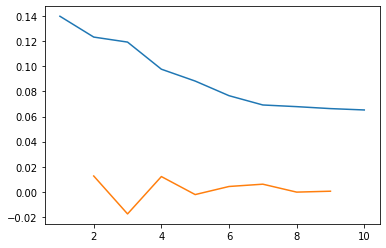

Рекомендованное количество кластеров: 2


In [86]:
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2
print("Рекомендованное количество кластеров:", k)

Установим кол-во кластеров для построения графиков и работы алгоритма k-means:

In [87]:
clusters_amount = 3

Построим дендограмму

In [88]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

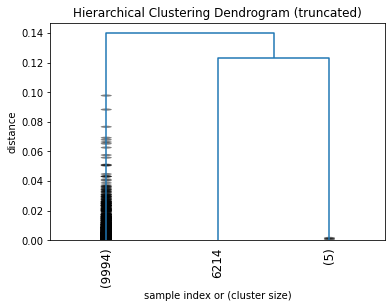

In [89]:
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=clusters_amount,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

И диаграмму кластеров:

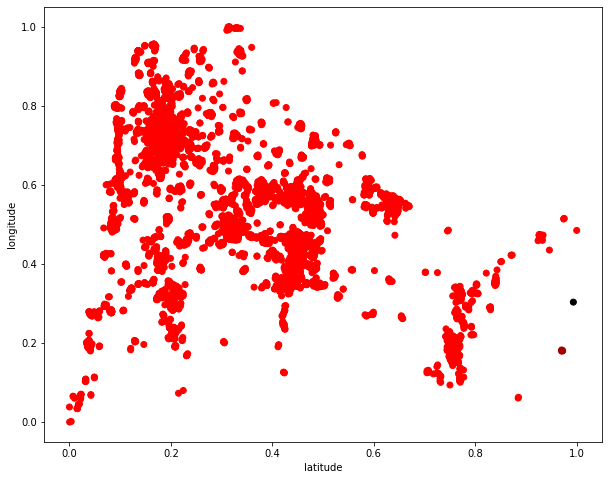

In [95]:
clusters = fcluster(data_linkage, clusters_amount, criterion='maxclust')

x = 1
y = 0
plt.figure(figsize=(10, 8))
plt.scatter(data_normalised[:,x], data_normalised[:,y], c=clusters, cmap='flag')
plt.xlabel(columns[x])
plt.ylabel(columns[y])
plt.show()

Выведем некоторую статистику по кластерам - кол-во объектов и средне значение параметра по кластеру

In [96]:
data['Agglomerative'] = clusters
result = data.groupby('Agglomerative')[columns].mean()
result['Amount'] = data.groupby('Agglomerative').size().values
result

,longitude,latitude,Amount
Agglomerative,,,
1,-1.417274,52.570142,9994
2,-4.230024,57.474380,5
3,-3.334760,57.643200,1


Посмотреть содержание какого-нибудь конкретного кластера

In [97]:
cluster_num = 4
data[data['Agglomerative'] == cluster_num]

,longitude,latitude,Agglomerative



---
Теперь построим кластеризацию с помощью алгоритма Kmeans, а точнее его усовершенствованной версии k-means++ (начальные точки выбираются так, чтобы они находились как можно дальше друг от друга, а не случайным образом)

In [98]:
km = KMeans(n_clusters=clusters_amount, init='k-means++').fit(data_normalised)

Построим диаграмму кластеров

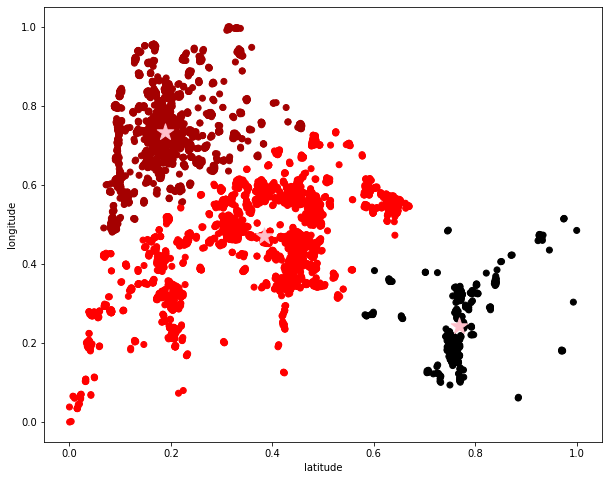

In [99]:
clust = km.labels_ +1

x = 1
y = 0
centroids = km.cluster_centers_
plt.figure(figsize=(10, 8))
plt.scatter(data_normalised[:,x], data_normalised[:,y], c=km.labels_, cmap='flag')
plt.scatter(centroids[:, x], centroids[:, y], marker='*', s=300,
            c='pink', label='centroid')
plt.xlabel(columns[x])
plt.ylabel(columns[y])
plt.show()

Статистика по кластерам:

In [100]:
data['KMeans'] = km.labels_+1
result = data.groupby('KMeans')[columns].mean()
result['Количество'] = data.groupby('KMeans').size().values
result

,longitude,latitude,Количество
KMeans,,,
1,-2.115696,53.005502,5205
2,-0.185879,51.520451,4160
3,-3.784680,55.924885,635


Посмотреть содержание какого-нибудь конкретного кластера

In [101]:
cluster_num = 4
data[data['KMeans'] == cluster_num]

,longitude,latitude,Agglomerative,KMeans


Сохранение результатов в файл

In [102]:
result_file = 'result/result_urbanGb.csv'
data.to_csv(result_file, index=False)

-----------

А теперь нарисуем кластеры на карте!!


Парсим файл с результатом:

In [103]:
result_file = 'result/result_urbanGb.csv'

res_data = pd.read_csv(result_file)
res_data.head()

,longitude,latitude,Agglomerative,KMeans
0,-1.80638,51.5949,1,1
1,-1.53085,53.7971,1,1
2,-2.17967,53.8578,1,1
3,-1.08601,50.8492,1,2
4,-2.10596,52.9586,1,1


Определим Bounding Box - область, определяющуюся 4 крайними значениями широты и долготы, таким образом область будет включать в себя все пространственные точки.

In [104]:
BBox = ((res_data.longitude.min(), res_data.longitude.max(), res_data.latitude.min(), res_data.latitude.max()))
print(BBox)

(-5.54982, 1.75362, 50.0959, 57.6934)


Импортируем библиотеку geopandas:

In [105]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

Прочитаем из файла .shp данные - это карта Великобритании, найденная мною здесь https://gadm.org/download_country.html

<AxesSubplot:>

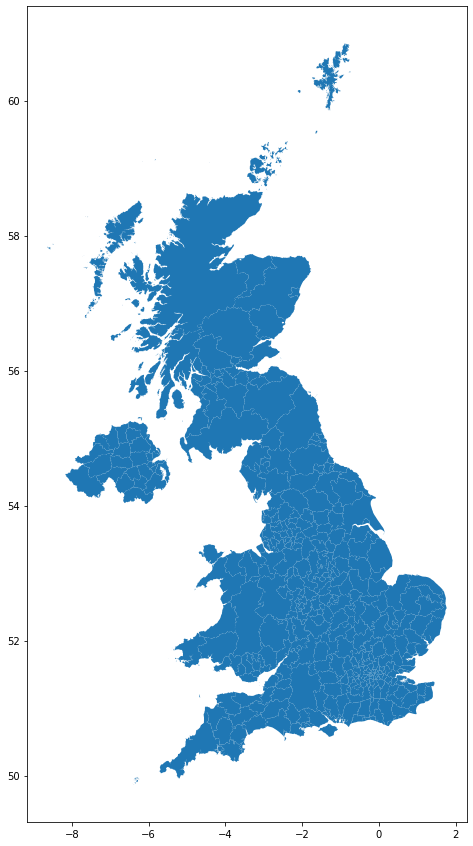

In [106]:
map_file = 'result/map/gadm40_GBR_3.shp'
gb_map = gpd.read_file(map_file)

fig, ax = plt.subplots(figsize = (15, 15))
gb_map.plot(ax = ax)

Теперь из обычного DataFrame создадим GeoDataFrame.

Сначала создадим из каждой строки geo_data точки Point, используя систему координат EPSG:4326 (широта, долгота)

In [107]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(res_data['longitude'], res_data['latitude'])]
geometry[:3]

И создадим GeoDataFrame на основе исходных данных, указанной системы координат и листа созданных точек:

In [108]:
geo_data = gpd.GeoDataFrame(res_data,
                            crs=crs,
                            geometry=geometry)
geo_data.head()

/home/renett/Repositories/python/data-mining-course/venv/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,longitude,latitude,Agglomerative,KMeans,geometry
0,-1.80638,51.5949,1,1,POINT (-1.80638 51.59490)
1,-1.53085,53.7971,1,1,POINT (-1.53085 53.79710)
2,-2.17967,53.8578,1,1,POINT (-2.17967 53.85780)
3,-1.08601,50.8492,1,2,POINT (-1.08601 50.84920)
4,-2.10596,52.9586,1,1,POINT (-2.10596 52.95860)


Выберем, по какому методу кластеризации построить изображение: Means или Agglomerative

In [111]:
clusterization_algo = 'KMeans'

Построим изображение!

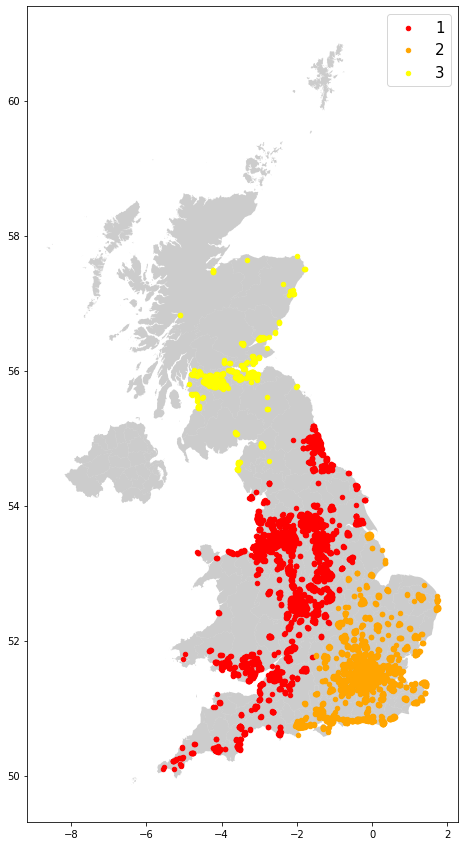

In [112]:
fig, ax = plt.subplots(figsize = (15,15))

geo_clusters = []
if clusterization_algo == 'KMeans':
    geo_clusters = km.labels_
else:
    geo_clusters = clusters

gb_map.plot(ax=ax, alpha=0.4, color="grey")

colors = ["blue", "red", "orange", "yellow", "pink", "green"]
for i in range(1, clusters_amount+1):
    geo_data[geo_data[clusterization_algo]==i].plot(ax=ax, markersize=20, color=colors[i], marker="o", label=i)

plt.legend(prop={'size': 15})

-------------
Результаты!
-------------

1. Случай, когда было выбрано 10_000 объектов таким образом, что по методу локтя было рекомендовано построить 5 кластеров. В данном случае алгоритм kmeans выдал более интересный (объекты лучше распределены, размеры кластеров не отличаются сильно)
**Иерархическая кластеризация**
![diagram](result/five/5_agglo.png)

    Дендограмма:
![dendo](result/five/5_agglo_dend.png)

**Kmeans**
![diagram](result/five/5_kmeans.png)


**Сравнение полученнных карт:**
![agglo_map](result/five/5_agglo_map.png) ![kmeans_map](result/five/5_kmeans_map.png)
слева: иерархический метод, справа - kmeans
2. Случай, когда из сэмпла данных получилось 3 кластера.
**Иерархическая кластеризация**
![diagram](result/three/3_agglo.png)

    Дендограмма:
![dendo](result/three/3_agglo_dend.png)

**Kmeans**
![diagram](result/three/3_kmeans.png)


**Сравнение полученнных карт:**
![agglo_map](result/three/3_agglo_map.png) ![kmeans_map](result/three/3_kmeans_map.png)
слева: иерархический метод, справа - kmeans